In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

In [2]:
out_train=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Train_Thermobar_Format')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Liq_train=out_train['Liqs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
Liq_train_noID_noT=Liq_train.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
Cpx_Liq_Combo_train=pd.concat([Cpx_train_noID_noT, Liq_train_noID_noT], axis=1)
x_train=Cpx_Liq_Combo_train.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_GPa']*10

In [3]:
## Test dataset
out_test=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Test_Thermobar_Format')
out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']
Liq_test=out_test['Liqs']
Cpx_test_noID_noT=Cpx_test.drop(['Sample_ID_Cpx'], axis=1)
Liq_test_noID_noT=Liq_test.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
Cpx_Liq_Combo_test=pd.concat([Cpx_test_noID_noT, Liq_test_noID_noT], axis=1)
x_test=Cpx_Liq_Combo_test.values
y_test_T=out_test_input['T_K']
y_test_P=out_test_input['P_GPa']*10

In [4]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Define the regressor, in our case the Extra Tree Regressor
regr_T = ExtraTreesRegressor(n_estimators=450, criterion='mse', max_features=10,
                           random_state=120) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=450, criterion='mse', max_features=10,
                           random_state=120) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())

ExtraTreesRegressor(max_features=10, n_estimators=450, random_state=120)

In [5]:
x_test_scaled=scaler.transform(x_test)

## Predicting the test data for temp

'RMSE= 55.18753'

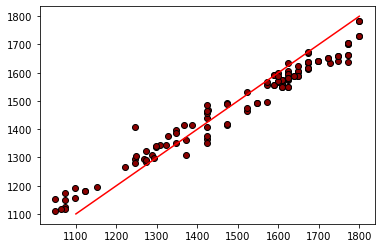

In [6]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)
Stats_T['R2']
Stats_T['RMSE']

## Predicting the test data for Press

'RMSE= 3.40177'

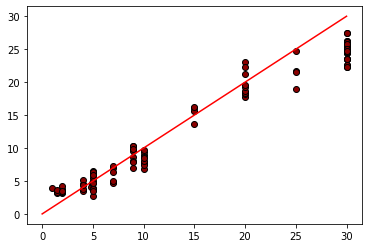

In [7]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
Stats_P['R2']
Stats_P['RMSE']

In [8]:
type(scaler)

sklearn.preprocessing._data.StandardScaler

In [9]:
from pickle import dump
dump(scaler, open('scaler_Petrelli2020_Cpx_Liq.pkl', 'wb'))
dump(regr_P, open('ETR_Press_Petrelli2020_Cpx_Liq.pkl', 'wb'))
dump(regr_T, open('ETR_Temp_Petrelli2020_Cpx_Liq.pkl', 'wb'))

In [10]:
from pickle import load
scaler_P2020_Cpx_Liq=load(open('scaler_Petrelli2020_Cpx_Liq.pkl', 'rb'))
ETR_Temp_P2020_Cpx_Liq=load(open('ETR_Temp_Petrelli2020_Cpx_Liq.pkl', 'rb'))
ETR_Press_P2020_Cpx_Liq=load(open('ETR_Press_Petrelli2020_Cpx_Liq.pkl', 'rb'))

## Predicting from saved

In [11]:
def P_Petrelli2021(cpx_comps, liq_comps):
    cpx_test=cpx_comps.copy()
    liq_test=liq_comps.copy()
    cpx_test_noID_noT=cpx_test.drop(['Sample_ID_Cpx'], axis=1)
    liq_test_noID_noT=liq_test.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
    cpx_liq_combo_test=pd.concat([cpx_test_noID_noT, liq_test_noID_noT], axis=1)
    x_test=cpx_liq_combo_test.values
    scaler_P2020_Cpx_Liq=load(open('scaler_Petrelli2020_Cpx_Liq.pkl', 'rb'))
    ETR_Press_P2020_Cpx_Liq=load(open('ETR_Press_Petrelli2020_Cpx_Liq.pkl', 'rb'))  
    x_test_scaled=scaler_P2020_Cpx_Liq.transform(x_test)
    Pred_P_kbar=ETR_Press_P2020_Cpx_Liq.predict(x_test_scaled)
    return Pred_P_kbar

def T_Petrelli2021(cpx_comps, liq_comps):
    cpx_test=cpx_comps.copy()
    liq_test=liq_comps.copy()
    cpx_test_noID_noT=cpx_test.drop(['Sample_ID_Cpx'], axis=1)
    liq_test_noID_noT=liq_test.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'CoO_Liq', 'CO2_Liq'], axis=1)
    cpx_liq_combo_test=pd.concat([cpx_test_noID_noT, liq_test_noID_noT], axis=1)
    x_test=cpx_liq_combo_test.values
    scaler_P2020_Cpx_Liq=load(open('scaler_Petrelli2020_Cpx_Liq.pkl', 'rb'))
    ETR_Temp_P2020_Cpx_Liq=load(open('ETR_Temp_Petrelli2020_Cpx_Liq.pkl', 'rb'))  
    x_test_scaled=scaler_P2020_Cpx_Liq.transform(x_test)
    Pred_T_K=ETR_Temp_P2020_Cpx_Liq.predict(x_test_scaled)
    return Pred_T_K

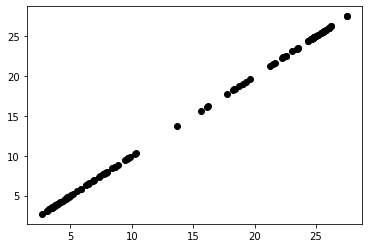

In [12]:
P_func=P_Petrelli2021(cpx_comps=Cpx_test, liq_comps=Liq_test)
plt.plot(predicted_P, P_func, 'ok')